### Load the libraries

In [1]:
# Code debug and development mode
%load_ext autoreload
%autoreload 2

In [3]:
# Warnings settings
import warnings
warnings.filterwarnings('ignore')

# General data visualization and manipulation
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

import proplot
proplot.rc['figure.facecolor'] = 'white'

# import open2c libraries
import bioframe
import cooler
import cooltools
import cooltools.api.expected as expected

# Other packages
import glob
import os

In [4]:
# Setting for all runs:
nthreads = 10
resolution = 1000

### Prepare the output

In [13]:
cvd_dct = {}
output = "../data/scalings/"

In [14]:
!mkdir {output}

### Pre-load all datasets

In [26]:
FILES = {}
ARMS = {}
LABELS = {}

In [27]:
genomes = ['danRer11', 'oryLat2', 'xenTro10', 'dm6', 'hg38', 'hg38_Abramo', 'mm10']

In [28]:
# danRer11 data:
arms = pd.read_csv('../data/genomes/danRer11/danRer11.armsizes.txt')
arms.loc[:, 'name'] = arms.apply(lambda x: f"{x.chrom}:{x.start}-{x.end}", axis=1)

files = glob.glob('../data/coolers/danRer11/*mapq_30*.mcool')
labels = list(map(lambda x: x.split('/')[-1].split('.danrer11')[0], files))
files = dict(zip(labels, files))

ARMS['danRer11'] = arms.copy()
FILES['danRer11'] = dict(files)
LABELS['danRer11'] = list(labels)

In [29]:
# oryLat2 data
chromsizes = bioframe.fetch_chromsizes('oryLat2', as_bed=True).query("chrom not in ['chrM']")
chromnames = [x for x in clr.chromnames if x in chromsizes.chrom.values]
cens = bioframe.fetch_centromeres('oryLat2')
arms = bioframe.make_chromarms(chromsizes, cens, cols_chroms=chromsizes.columns)
arms.start = arms.start.astype(int)
arms.end = arms.end.astype(int)

files = glob.glob('../data/coolers/oryLat2/*mapq_30*.mcool')
labels = list(map(lambda x: x.split('/')[-1].split('.oryLat2')[0], files))
files = dict(zip(labels, files))

ARMS['oryLat2'] = arms.copy()
FILES['oryLat2'] = dict(files)
LABELS['oryLat2'] = list(labels)

In [75]:
# xenTro10 data
chromsizes = bioframe.fetch_chromsizes('xenTro10', as_bed=True).query("chrom not in ['chrM']")
chromnames = [x for x in clr.chromnames if x in chromsizes.chrom.values]
cens = bioframe.fetch_centromeres('xenTro10')
arms = bioframe.make_chromarms(chromsizes, cens, cols_chroms=chromsizes.columns)
arms.start = arms.start.astype(int)
arms.end = arms.end.astype(int)
arms.loc[:, 'chrom'] = arms.chrom.str.capitalize()

files = glob.glob('../data/coolers/xenTro10/*mapq_30*.mcool')
labels = list(map(lambda x: x.split('/')[-1].split('.xenTro10')[0], files))
files = dict(zip(labels, files))

ARMS['xenTro10'] = arms.copy()
FILES['xenTro10'] = dict(files)
LABELS['xenTro10'] = list(labels)

In [81]:
# mouse data
chromsizes = bioframe.fetch_chromsizes('mm10', as_bed=True).query("chrom not in ['chrM', 'chrY']")
chromnames = [x for x in clr.chromnames if x in chromsizes.chrom.values]
cens = bioframe.fetch_centromeres('mm10')
arms = bioframe.make_chromarms(chromsizes, cens, cols_chroms=chromsizes.columns)
arms.start = arms.start.astype(int)
arms.end = arms.end.astype(int)

files = glob.glob('../data/coolers/mm10/*.mapq_30.1000.mcool')

labels = list(map(lambda x: x.split('/')[-1].split('.mm10')[0], files)) # ("Du_" if "Du" in x else "Ke_") + 
files = dict(zip(labels, files))

ARMS['mm10'] = arms.copy()
FILES['mm10'] = dict(files)
LABELS['mm10'] = list(labels)

In [32]:
# human data
chromsizes = bioframe.fetch_chromsizes('hg38', as_bed=True).query("chrom not in ['chrM', 'chrY']")
chromnames = [x for x in clr.chromnames if x in chromsizes.chrom.values]
cens = bioframe.fetch_centromeres('hg38')
arms = bioframe.make_chromarms(chromsizes, cens, cols_chroms=chromsizes.columns)
arms.start = arms.start.astype(int)
arms.end = arms.end.astype(int)

files = glob.glob('../data/coolers/hg38/*.hg38.mapq_30.1000.mcool')
labels = list(map(lambda x: x.split('/')[-1].split('.hg38')[0], files))
files = dict(zip(labels, files))

ARMS['hg38'] = arms.copy()
FILES['hg38'] = dict(files)
LABELS['hg38'] = list(labels)

In [33]:
# Abramo hg38 data:
files = glob.glob('../data/coolers/hg38_Abramo2019/*.hg38.mapq_30.1000.mcool')
labels = list(map(lambda x: x.split('/')[-1].split('.hg38')[0], files))
files = dict(zip(labels, files))

ARMS['hg38_Abramo'] = arms.copy()
FILES['hg38_Abramo'] = dict(files)
LABELS['hg38_Abramo'] = list(labels)

In [34]:
# Drosophila data
chromsizes = bioframe.fetch_chromsizes('dm6', 
    chrom_patterns=('^chr[0-9][L,R]+$', '^chr[0-9]+$', '^chr[XY]$', '^chrM$'), 
    as_bed=True)
chromnames = [x for x in clr.chromnames if x in chromsizes.chrom.values]
cens = bioframe.fetch_centromeres('dm6')
arms = bioframe.make_chromarms(chromsizes, cens, cols_chroms=chromsizes.columns)
arms.start = arms.start.astype(int)
arms.end = arms.end.astype(int)

files = glob.glob('../data/coolers/dm6/*.dm6.mapq_30.1000.mcool')
labels = list(map(lambda x: x.split('/')[-1].split('.dm6')[0], files))
files = dict(zip(labels, files))

ARMS['dm6'] = arms.copy()
FILES['dm6'] = dict(files)
LABELS['dm6'] = list(labels)

### Calculate all the scalings

In [82]:
for genome in ['mm10']: #genomes:
    
    cvd_dct[genome] = {}

    for k in LABELS[genome]:
        file = FILES[genome][k]
        print(genome, k, file.split('/')[-1], resolution)

        try:
            # Load a Hi-C map at a 1kb resolution from a cooler file:
            clr = cooler.Cooler(f'{file}::/resolutions/{resolution}')

            # cvd == contacts-vs-distance
            cvd_smooth_agg = cooltools.expected_cis(
                clr=clr,
                view_df=ARMS[genome],
                smooth=True,
                aggregate_smoothed=True,
                nproc=nthreads
            )

            # Reconstruct bp-resolution coordinates of the bins:
            cvd_smooth_agg.loc[:, 's_bp'] = cvd_smooth_agg['dist'] * resolution

            # Remove too-close to diagonal: 
            cvd_smooth_agg.loc[cvd_smooth_agg['dist'] < 2, 'balanced.avg.smoothed.agg'] = np.nan

            # Store the data:
            cvd_dct[genome][k]       = cvd_smooth_agg.copy()
            cvd_smooth_agg.to_csv(f'{output}/{k}.{resolution}.{genome}.cvd_smooth_agg.csv')

        except Exception as e:
            print(e)

mm10 500_mESCs 500_mESCs.mm10.mapq_30.1000.mcool 1000
mm10 2-cell_alpha-amanitin_treated_Hi-C 2-cell_alpha-amanitin_treated_Hi-C.mm10.mapq_30.1000.mcool 1000
mm10 4-cell 4-cell.mm10.mapq_30.1000.mcool 1000
mm10 Ke_8-cell Ke_8-cell.mm10.mapq_30.1000.mcool 1000
mm10 MII_oocyte MII_oocyte.mm10.mapq_30.1000.mcool 1000
mm10 Ke_sperm Ke_sperm.mm10.mapq_30.1000.mcool 1000
mm10 Du_sperm Du_sperm.mm10.mapq_30.1000.mcool 1000
mm10 invitro_late_2-cell invitro_late_2-cell.mm10.mapq_30.1000.mcool 1000
mm10 late_2-cell late_2-cell.mm10.mapq_30.1000.mcool 1000
mm10 invitro_8-cell invitro_8-cell.mm10.mapq_30.1000.mcool 1000
mm10 2-cell 2-cell.mm10.mapq_30.1000.mcool 1000
mm10 MII_oocytes MII_oocytes.mm10.mapq_30.1000.mcool 1000
mm10 E3.5 E3.5.mm10.mapq_30.1000.mcool 1000
mm10 zygote zygote.mm10.mapq_30.1000.mcool 1000
mm10 early_2-cell early_2-cell.mm10.mapq_30.1000.mcool 1000
mm10 alpha-amanitin_45h alpha-amanitin_45h.mm10.mapq_30.1000.mcool 1000
mm10 PN3_zygote PN3_zygote.mm10.mapq_30.1000.mcool 100

### Plot all the scalings and calculate positions of the humps

Plotting the scalings with minimal smoothing.

Humps are calculated semi-manually (for each dataset we first manually determined the range of possible locaitons of second hump, which can be a magnifude difference for different species). 

In [38]:
import proplot
proplot.rc.cycle = 'Qual2'
proplot.rc['figure.facecolor'] = 'white'

In [39]:
first_hump_dct = {}
second_hump_dct = {}

In [46]:
for genome in genomes:
    first_hump_dct[genome] = {}
    second_hump_dct[genome] = {}

#### Read oryLat data

In [48]:
genome = "oryLat2"
keys = ['HiC_st9',
    'HiC_st10',
    'HiC_st10.5',
    'HiC_st11',
    'HiC_st11.5',
    'HiC_st12',
    'HiC_st13',
    'HiC_st14',
    'HiC_st15',
    'HiC_st18',
    'HiC_st21',
    'HiC_st27',
    'HiC_fibro',]
titles = [x.split('_')[1].replace('st', '')+(' hpf' if not 'fibro' in x else '') for x in keys]

In [49]:
cmap = mpl.cm.get_cmap('spectral', len(titles))
cmap.colors = [cmap(x) for x in range(cmap.N)]

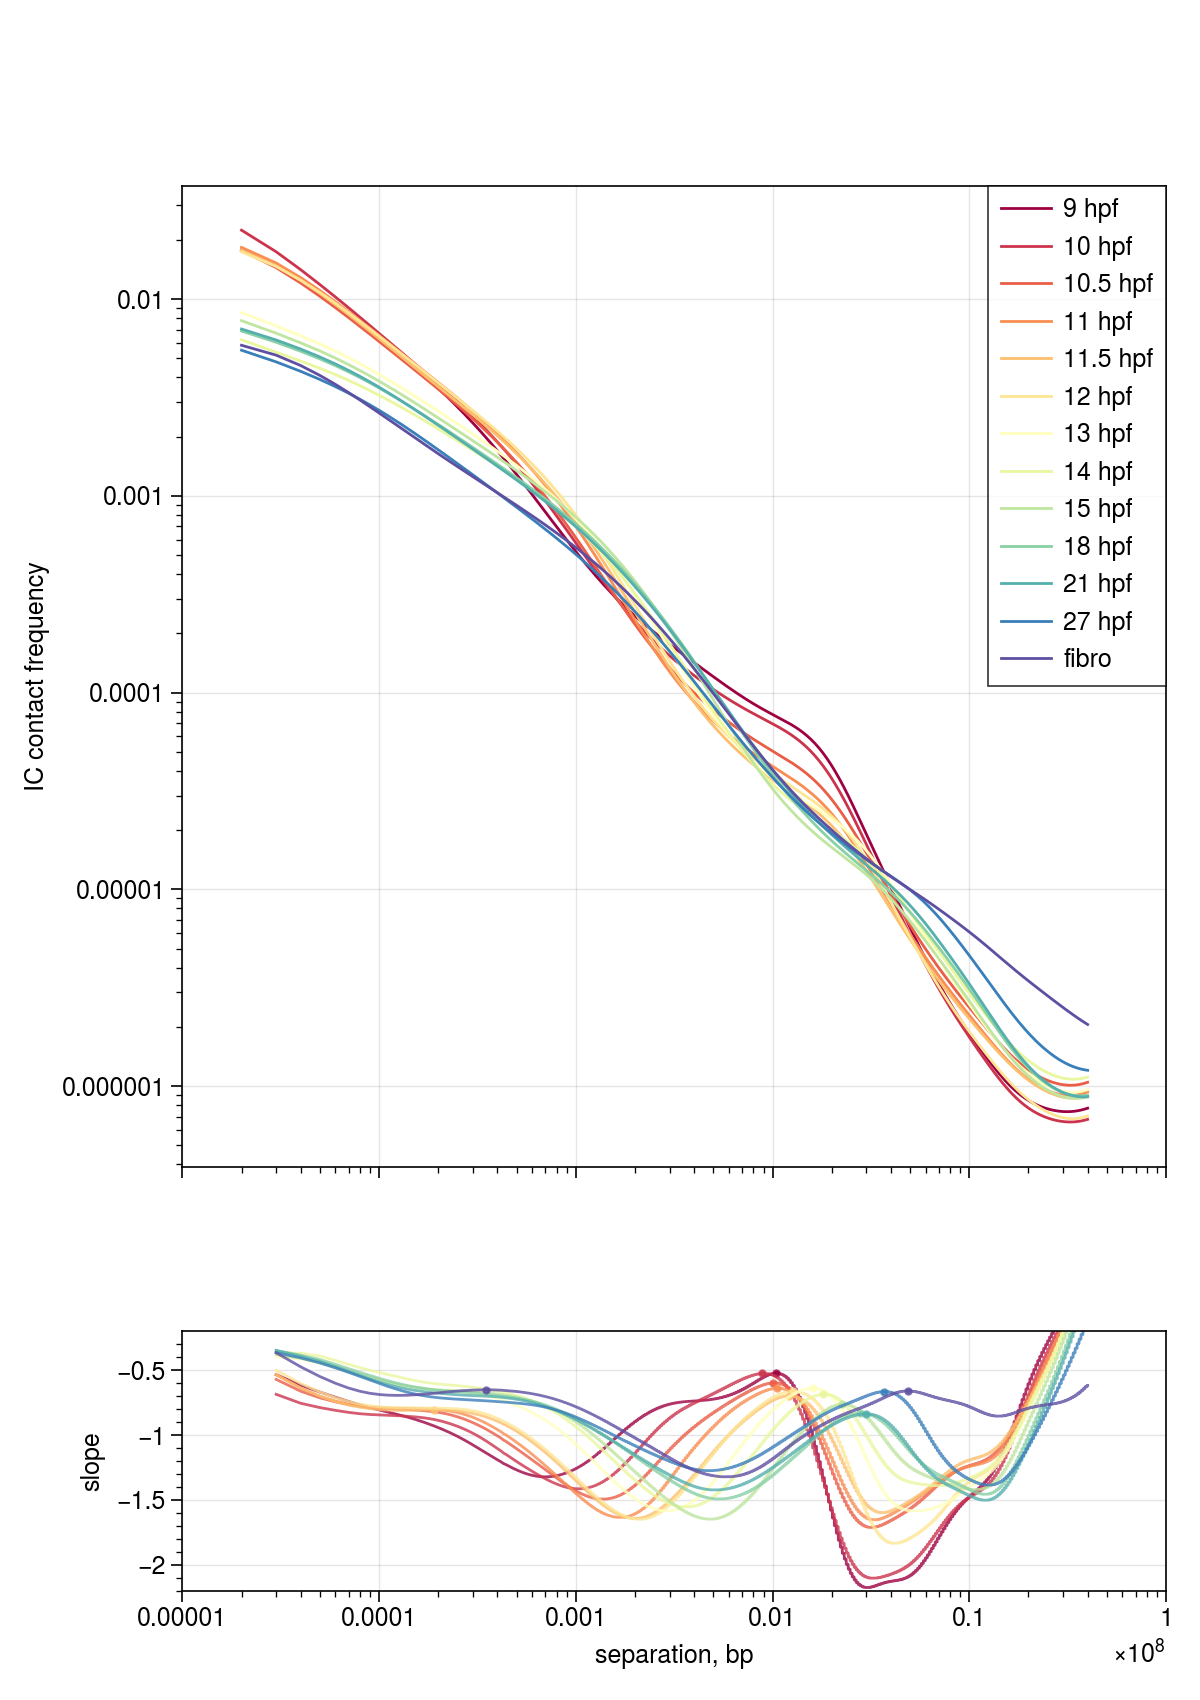

In [50]:
f, axs = plt.subplots(
    figsize=(6,8.5),
    nrows=2, 
    gridspec_kw={'height_ratios':[10,2]}, 
    sharex=True)

ax = axs[0]
ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)

ax = axs[1]
ax.set(
    ylim=(-2.2,-0.2),
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)


for i, (k, title) in enumerate(zip(keys, titles)):
        
    cvd_smooth_agg = cvd_dct[genome][k]
    cvd_merged = cvd_smooth_agg.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    der = np.gradient(np.log(cvd_merged['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged['s_bp']))
    
    ax = axs[0]
    ax.loglog(
        cvd_merged['s_bp'],
        cvd_merged['balanced.avg.smoothed.agg'],
        '-',
        markersize=2, 
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )

    ax = axs[1]
    ax.semilogx(
        cvd_merged['s_bp'],
        der,
        alpha=0.8,
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )
    
    # Smaller hump
    try: 
        idx = np.where((cvd_merged.s_bp>1e4) & (cvd_merged.s_bp<1e5))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        first_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]
        
        if not idx_true==idx[0]:
            ax.semilogx(
                cvd_merged['s_bp'].iloc[idx_true],
                der[[idx_true]],
                'o',
                markersize=2,
                alpha=0.8,
                linewidth=1 if not 'hpf' in title else 2,
                label=title,
                color=cmap.colors[i]
            )
    except Exception:
        pass
    
    # Larger hump
    try:
        idx = np.where((cvd_merged.s_bp>1e5) & (cvd_merged.s_bp<1e7))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        second_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]

        ax.semilogx(
            cvd_merged['s_bp'].iloc[idx_true],
            der[[idx_true]],
            'o',
            markersize=2,
            alpha=0.8,
            linewidth=1 if not 'hpf' in title else 2,
            label=title,
            color=cmap.colors[i]
        )
    except Exception as e:
        print(e)
        pass
    
axs[0].legend()
f.tight_layout()

plt.savefig(f'../figures/003_scalings_oryLat2_{resolution}.pdf')
plt.show()

### Read xenTro data:

In [51]:
genome = "xenTro10"
keys = [
 'stage8',
 'stage9',
 #'stage9RPB1MO.xenTro10.mapq_30.1000.mcool',
 'stage10',
 #'stage10RPB1MO.xenTro10.mapq_30.1000.mcool',
 'stage11',
 'stage12',
 'stage13',
 #'stage13CTCFRad21MO.xenTro10.mapq_30.1000.mcool',
 #'stage13Rad21MO.xenTro10.mapq_30.1000.mcool',
 'stage15',
]
titles = [x.split('.xenTro10')[0] for x in keys]

In [52]:
cmap = mpl.cm.get_cmap('spectral', len(titles))
cmap.colors = [cmap(x) for x in range(cmap.N)]

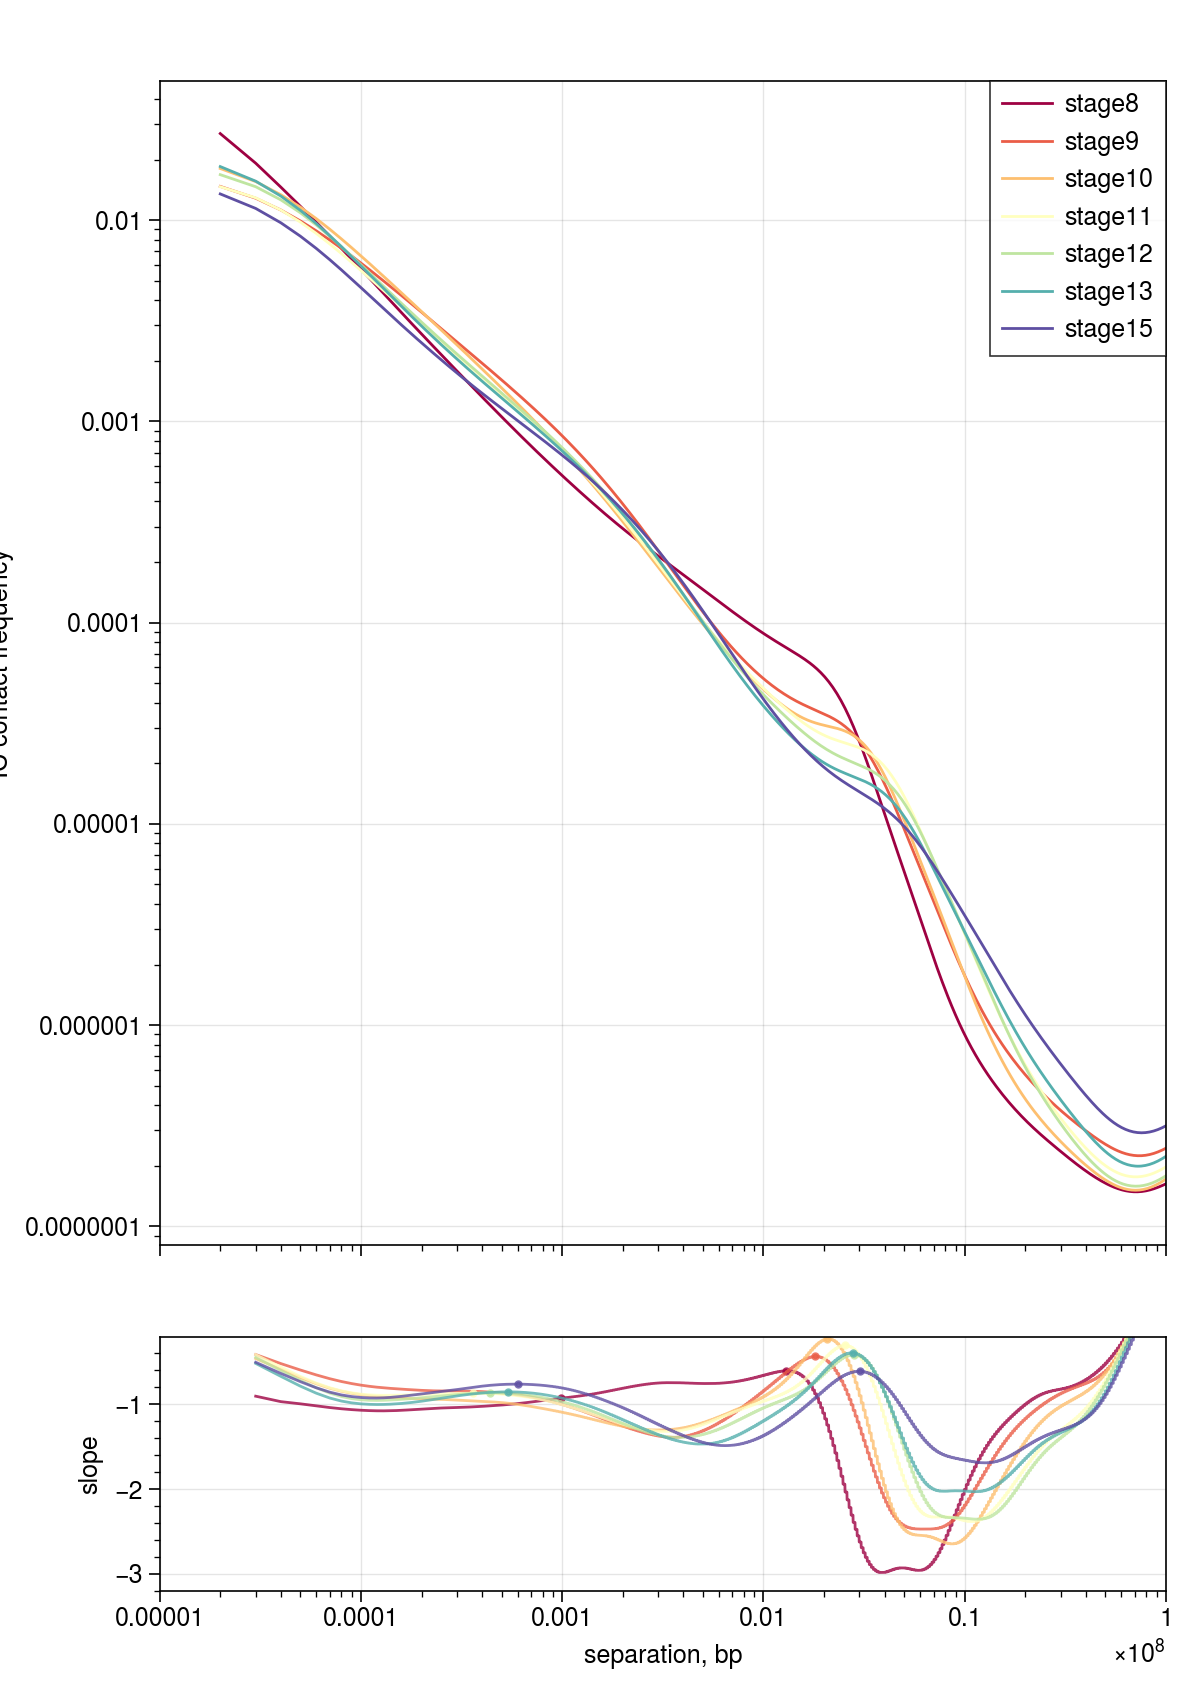

In [53]:
f, axs = plt.subplots(
    figsize=(6,8.5),
    nrows=2, 
    gridspec_kw={'height_ratios':[10,2]}, 
    sharex=True)

ax = axs[0]
ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)

ax = axs[1]
ax.set(
    ylim=(-3.2,-0.2),
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)


for i, (k, title) in enumerate(zip(keys, titles)):
        
    cvd_smooth_agg = cvd_dct[genome][k]
    cvd_merged = cvd_smooth_agg.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    der = np.gradient(np.log(cvd_merged['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged['s_bp']))
    
    ax = axs[0]
    ax.loglog(
        cvd_merged['s_bp'],
        cvd_merged['balanced.avg.smoothed.agg'],
        '-',
        markersize=2, 
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )

    ax = axs[1]
    ax.semilogx(
        cvd_merged['s_bp'],
        der,
        alpha=0.8,
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )
    
    # Smaller hump
    try: 
        idx = np.where((cvd_merged.s_bp>1e4) & (cvd_merged.s_bp<1e5))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        first_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]
        
        if not idx_true==idx[0]:
            ax.semilogx(
                cvd_merged['s_bp'].iloc[idx_true],
                der[[idx_true]],
                'o',
                markersize=2,
                alpha=0.8,
                linewidth=1 if not 'hpf' in title else 2,
                label=title,
                color=cmap.colors[i]
            )
    except Exception:
        pass
    
    # Larger hump
    try:
        idx = np.where((cvd_merged.s_bp>1e5) & (cvd_merged.s_bp<1e7))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        second_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]

        ax.semilogx(
            cvd_merged['s_bp'].iloc[idx_true],
            der[[idx_true]],
            'o',
            markersize=2,
            alpha=0.8,
            linewidth=1 if not 'hpf' in title else 2,
            label=title,
            color=cmap.colors[i]
        )
    except Exception as e:
        print(e)
        pass
    
axs[0].legend()
f.tight_layout()

plt.savefig(f'../figures/003_scalings_xenTro10_{resolution}.pdf')
plt.show()

### Read dm6 data

In [54]:
genome = "dm6"
keys = [
 # 'mitotic-nuclear-cycle-1-14',
 'nuclear-cycle-12',
 'nuclear-cycle-13',
 'nuclear-cycle-14',
 # 'nuclear-cycle-14-alpha-amanitin-injected',
 # 'nuclear-cycle-14-sh-zld',
 # 'nuclear-cycle-14-triptolide-injected',
 # 'nuclear-cycle-14-water-injected',
 '3-4h',
]

titles = list(keys)

In [62]:
cmap = mpl.cm.get_cmap('spectral', len(titles))#[np.newaxis, :, :3]
cmap.colors = [cmap(x) for x in range(cmap.N)]

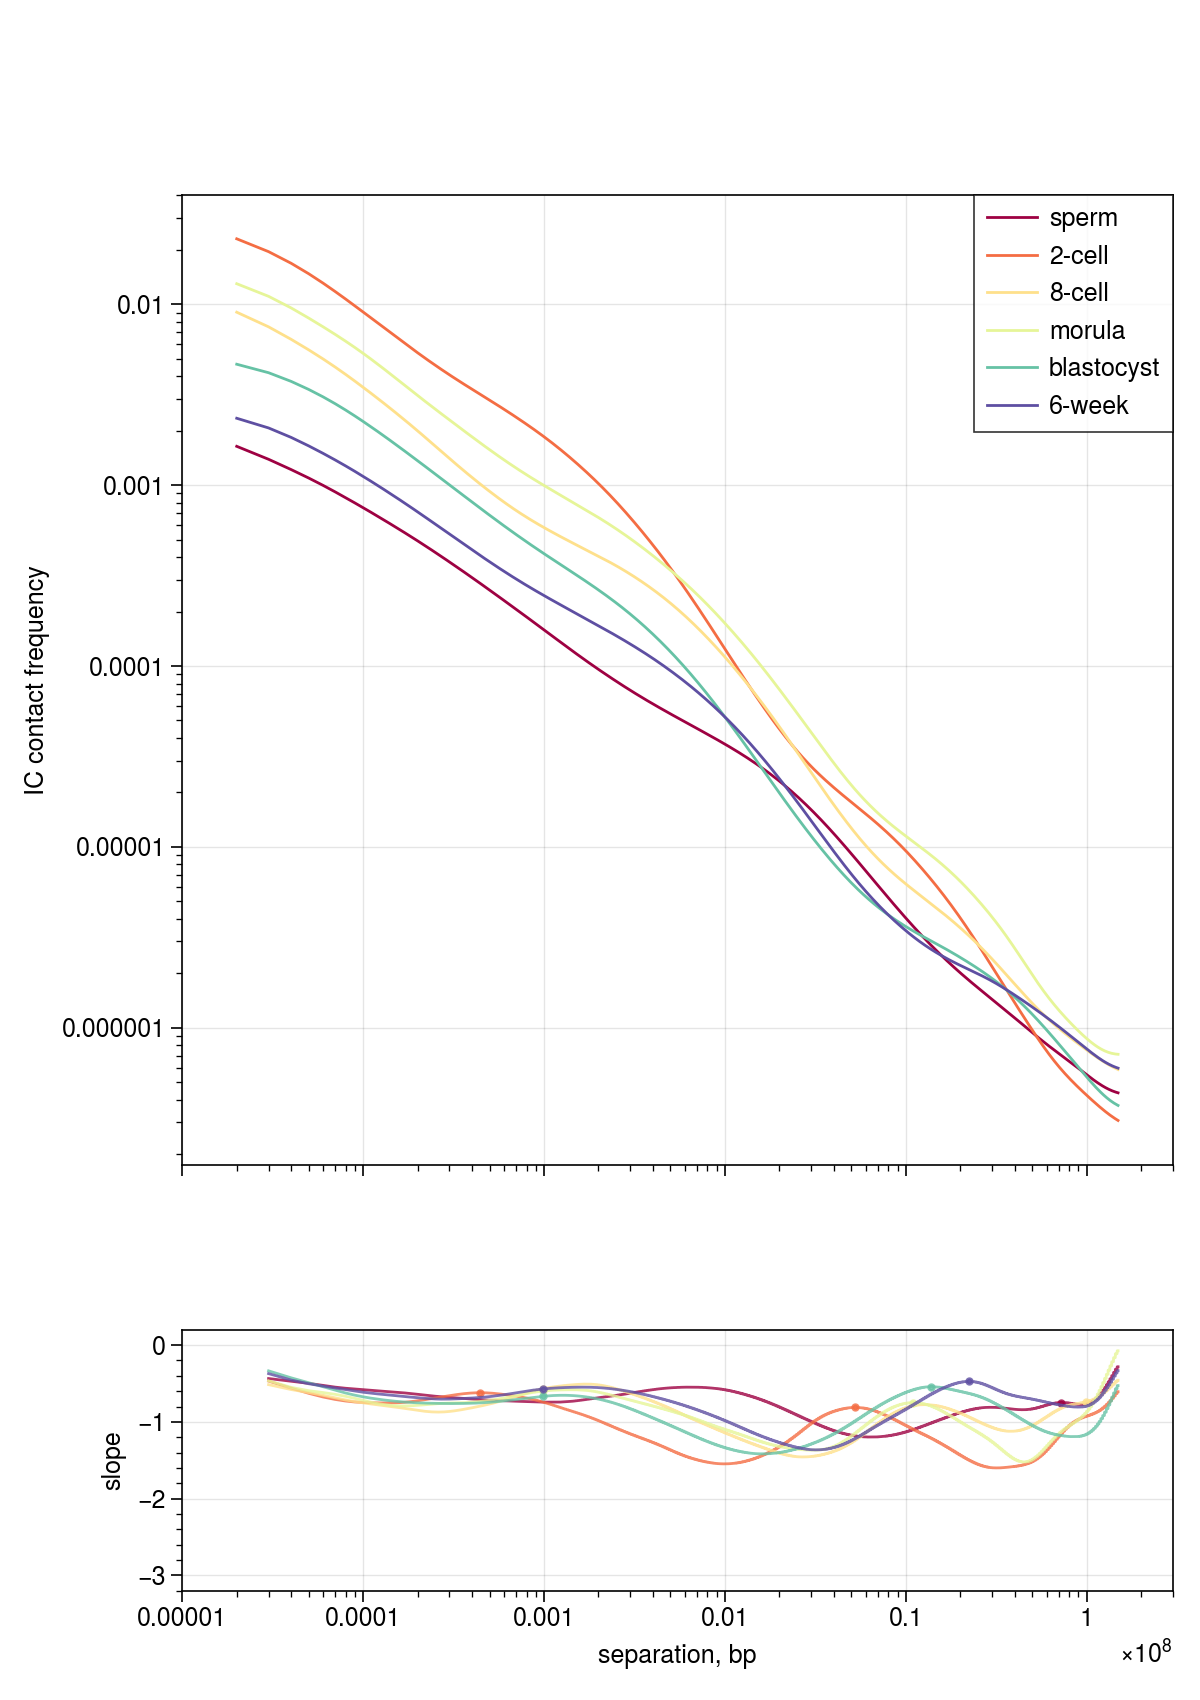

In [64]:
f, axs = plt.subplots(
    figsize=(6,8.5),
    nrows=2, 
    gridspec_kw={'height_ratios':[10,2]}, 
    sharex=True)

ax = axs[0]
ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,3e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)

ax = axs[1]
ax.set(
    ylim=(-3.2,0.2),
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)


for i, (k, title) in enumerate(zip(keys, titles)):
    
    cvd_smooth_agg = cvd_dct[genome][k].copy()
    cvd_merged = cvd_smooth_agg.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    der = np.gradient(np.log(cvd_merged['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged['s_bp']))
    
    ax = axs[0]
    ax.loglog(
        cvd_merged['s_bp'],
        cvd_merged['balanced.avg.smoothed.agg'],
        '-',
        markersize=2, 
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )

    ax = axs[1]
    ax.semilogx(
        cvd_merged['s_bp'],
        der,
        alpha=0.8,
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )
    
    # Smaller hump
    try: 
        idx = np.where((cvd_merged.s_bp>1e4) & (cvd_merged.s_bp<1e5))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        first_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]
        
        if not idx_true==idx[0]:
            ax.semilogx(
                cvd_merged['s_bp'].iloc[idx_true],
                der[[idx_true]],
                'o',
                markersize=2,
                alpha=0.8,
                linewidth=1 if not 'hpf' in title else 2,
                label=title,
                color=cmap.colors[i]
            )
    except Exception:
        pass
    
    # Larger hump
    try:
        idx = np.where((cvd_merged.s_bp>5e6) & (cvd_merged.s_bp<1e8))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        second_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]

        ax.semilogx(
            cvd_merged['s_bp'].iloc[idx_true],
            der[[idx_true]],
            'o',
            markersize=2,
            alpha=0.8,
            linewidth=1 if not 'hpf' in title else 2,
            label=title,
            color=cmap.colors[i]
        )
    except Exception as e:
        print(e)
        pass
    
axs[0].legend()
f.tight_layout()

plt.savefig(f'../figures/003_scalings_dm6_{resolution}.pdf')
plt.show()

### Read hg38 data

In [65]:
genome = "hg38"
keys = [
 'human_sperm_Hi-C',
 'human_2-cell_Hi-C',
 # 'human_2-cell_mixed_sample',
 'human_8-cell_Hi-C',
 # 'human_8-cell_amanitin_plus_CTCF_mRNA_mixed_sample',
 # 'human_8-cell_mixed_sample',
 # 'human_alpha_amanitin_8-cell_Hi-C',
 # 'human_amanitin-treated_8-cell_mixed_sample',
 'human_morula_Hi-C',
 'human_blastocyst_Hi-C',
 # 'human_morula_mixed_sample',
 # 'human_siCTCF_Hi-C',
 # 'human_single_blastocyst_ultra-low-input_Hi-C_replictae1',
 'human_6-week_Hi-C',
 # 'sperm_mixed_Hi-C'
]

titles = [x.split('_')[-2] for x in keys]

In [66]:
cmap = mpl.cm.get_cmap('spectral', len(titles))
cmap.colors = [cmap(x) for x in range(cmap.N)]

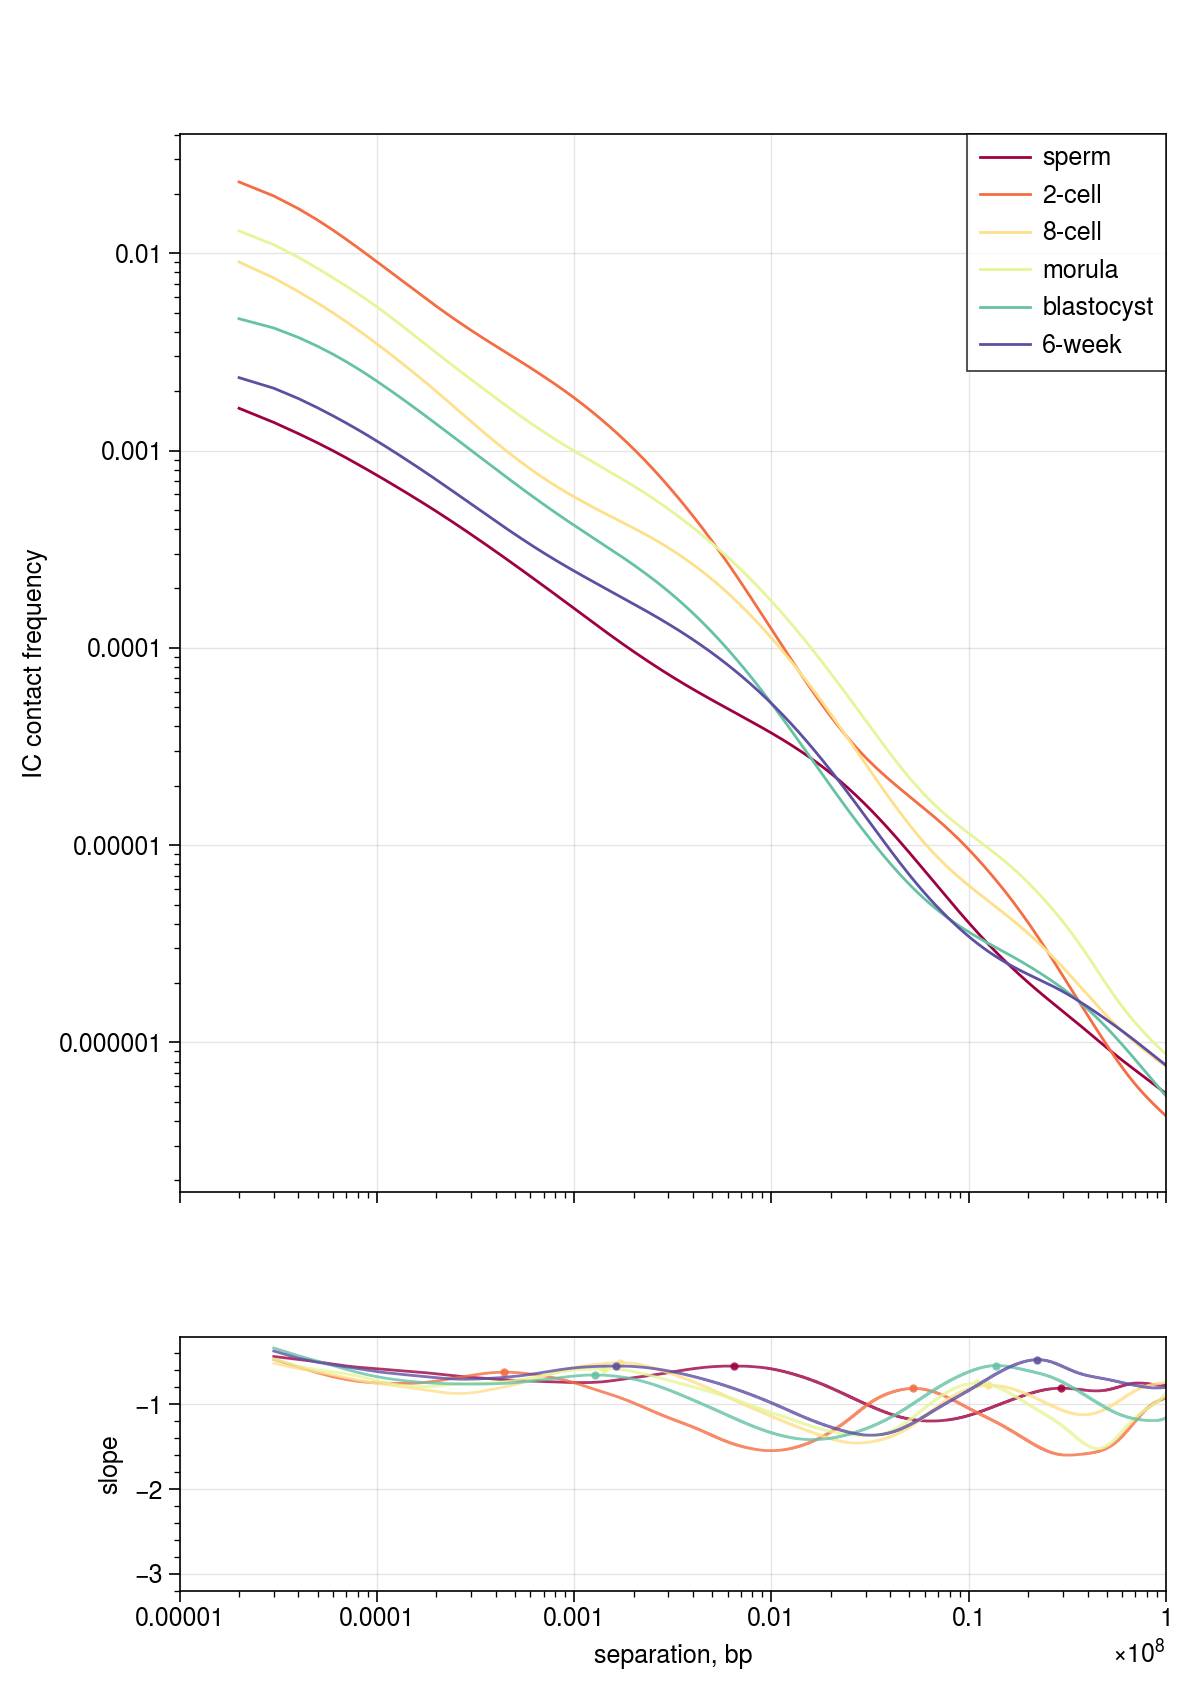

In [69]:
f, axs = plt.subplots(
    figsize=(6,8.5),
    nrows=2, 
    gridspec_kw={'height_ratios':[10,2]}, 
    sharex=True)

ax = axs[0]
ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)

ax = axs[1]
ax.set(
    ylim=(-3.2,-0.2),
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)


for i, (k, title) in enumerate(zip(keys, titles)):
    
    cvd_smooth_agg = cvd_dct[genome][k]
    cvd_merged = cvd_smooth_agg.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    der = np.gradient(np.log(cvd_merged['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged['s_bp']))
    
    ax = axs[0]
    ax.loglog(
        cvd_merged['s_bp'],
        cvd_merged['balanced.avg.smoothed.agg'],
        '-',
        markersize=2, 
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )

    ax = axs[1]
    ax.semilogx(
        cvd_merged['s_bp'],
        der,
        alpha=0.8,
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )
    
    # Smaller hump
    try: 
        idx = np.where((cvd_merged.s_bp>1e4) & (cvd_merged.s_bp<1e6))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        first_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]
        
        if not idx_true==idx[0]:
            ax.semilogx(
                cvd_merged['s_bp'].iloc[idx_true],
                der[[idx_true]],
                'o',
                markersize=2,
                alpha=0.8,
                linewidth=1 if not 'hpf' in title else 2,
                label=title,
                color=cmap.colors[i]
            )
    except Exception:
        pass
    
    # Larger hump
    try:
        idx = np.where((cvd_merged.s_bp>3*1e6) & (cvd_merged.s_bp<3*1e7))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        second_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]

        ax.semilogx(
            cvd_merged['s_bp'].iloc[idx_true],
            der[[idx_true]],
            'o',
            markersize=2,
            alpha=0.8,
            linewidth=1 if not 'hpf' in title else 2,
            label=title,
            color=cmap.colors[i]
        )
    except Exception as e:
        print(e)
        pass
    
axs[0].legend()
f.tight_layout()

plt.savefig(f'../figures/003_scalings_hg38_{resolution}.pdf')
plt.show()

### Read mm10 data

In [83]:
genome = "mm10"
keys = [
 'Du_sperm',
 'Ke_sperm',
 'zygote',
 # 'Du_500_mESCs',
 # 'Du_ICM',
 # 'Du_MII_oocytes',
 # 'Du_PN3_zygote',
 # 'Du_PN5_zygote',
 # 'Du_alpha-amanitin_20h',
 # 'Du_alpha-amanitin_45h',
 # 'Du_cortex',
 'early_2-cell',
 '2-cell',
 'late_2-cell',
 # 'Du_invitro_8-cell',
 # 'Du_invitro_late_2-cell',
 # 'Ke_2-cell_alpha-amanitin_treated_Hi-C',
 # 'Ke_2-cell_aphidicolin_treated_Hi-C',
 '4-cell',
 'Du_8-cell',
 'Ke_8-cell',
 'E3.5',
 'E7.5',
 # 'Ke_MII_oocyte',
 'mouse_morula_Hi-C',
 # 'Ke_mouse_single_E3.5_ultra-low-input_Hi-C',
]

titles = list(keys)

In [84]:
cmap = mpl.cm.get_cmap('spectral', len(titles))
cmap.colors = [cmap(x) for x in range(cmap.N)]

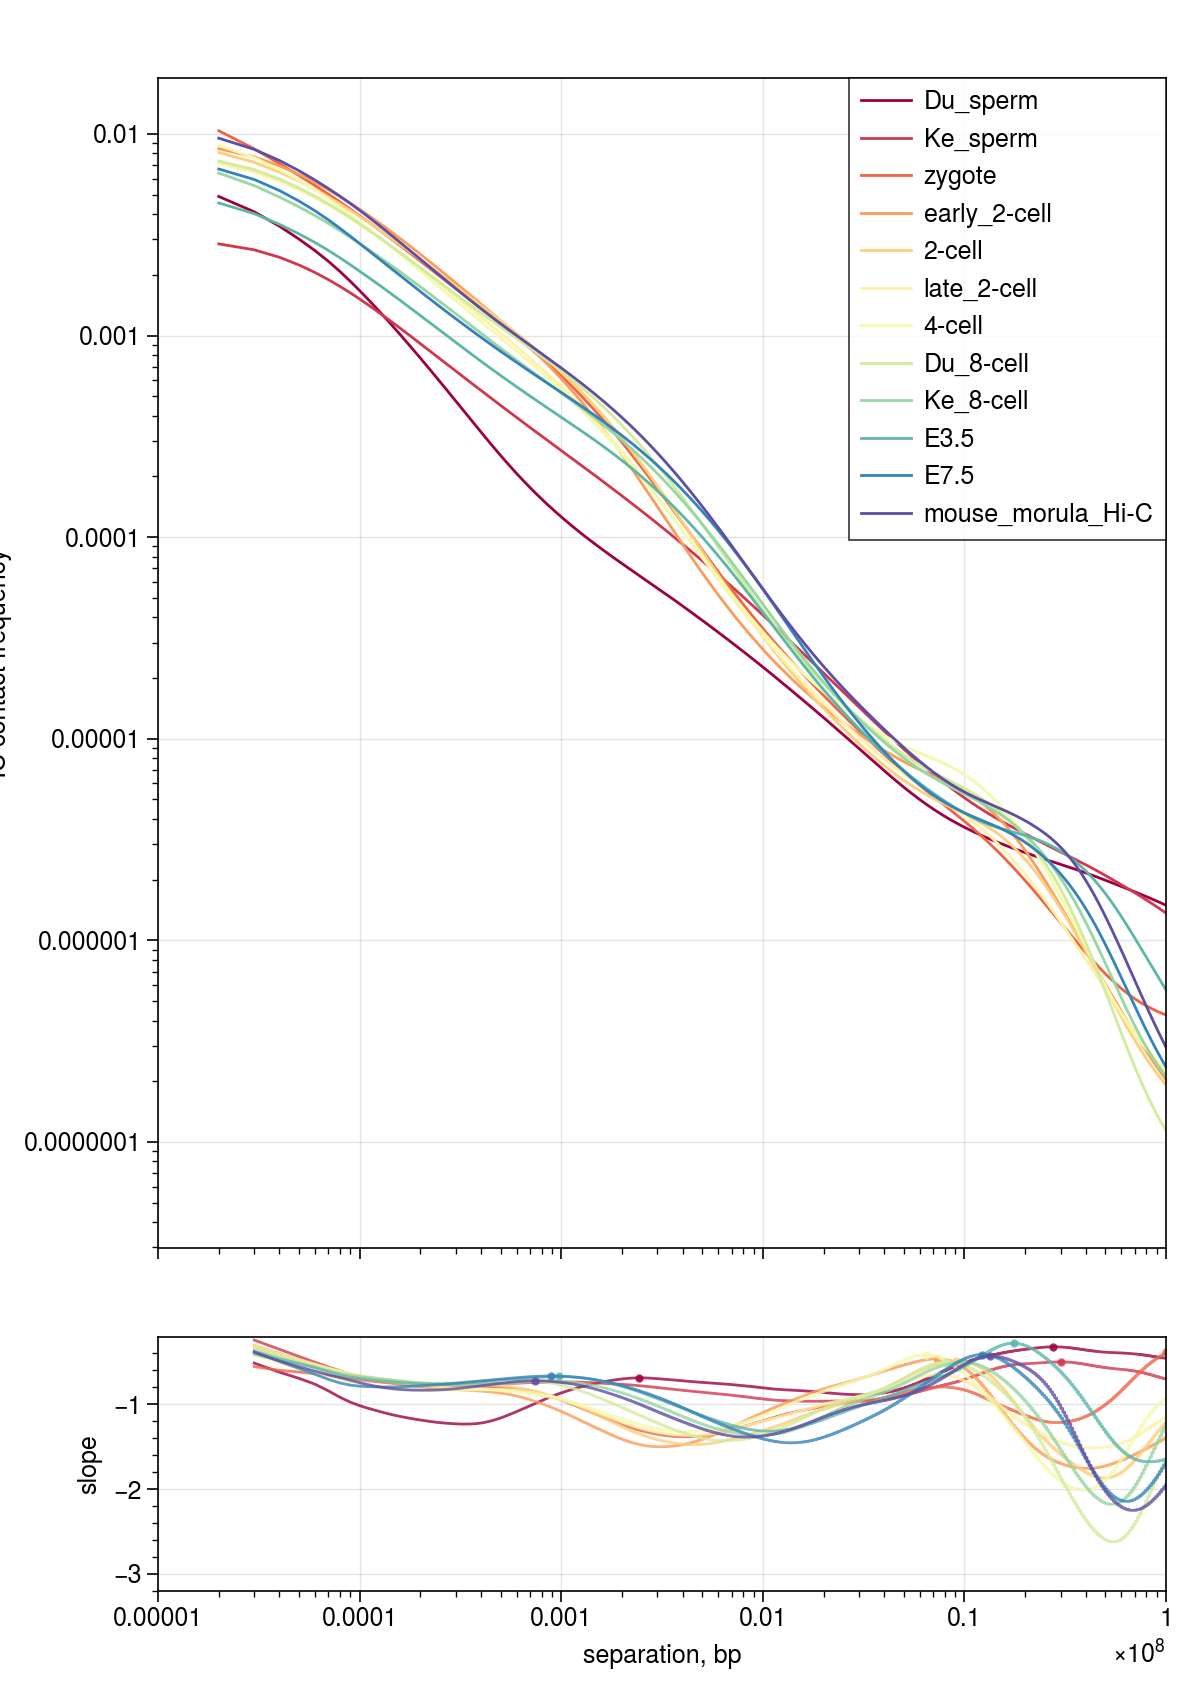

In [85]:
f, axs = plt.subplots(
    figsize=(6,8.5),
    nrows=2, 
    gridspec_kw={'height_ratios':[10,2]}, 
    sharex=True)

ax = axs[0]
ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)

ax = axs[1]
ax.set(
    ylim=(-3.2,-0.2),
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)


for i, (k, title) in enumerate(zip(keys, titles)):
    
    cvd_smooth_agg = cvd_dct[genome][k]
    cvd_merged = cvd_smooth_agg.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    der = np.gradient(np.log(cvd_merged['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged['s_bp']))
    
    ax = axs[0]
    ax.loglog(
        cvd_merged['s_bp'],
        cvd_merged['balanced.avg.smoothed.agg'],
        '-',
        markersize=2, 
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )

    ax = axs[1]
    ax.semilogx(
        cvd_merged['s_bp'],
        der,
        alpha=0.8,
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )
    
    # Smaller hump
    try: 
        idx = np.where((cvd_merged.s_bp>1e4) & (cvd_merged.s_bp<1e6))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        first_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]
        
        if not idx_true==idx[0]:
            ax.semilogx(
                cvd_merged['s_bp'].iloc[idx_true],
                der[[idx_true]],
                'o',
                markersize=2,
                alpha=0.8,
                linewidth=1 if not 'hpf' in title else 2,
                label=title,
                color=cmap.colors[i]
            )
    except Exception as e:
        print(e)
        pass
    
    # Larger hump
    try:
        idx = np.where((cvd_merged.s_bp>5*1e6) & (cvd_merged.s_bp<1e8))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        second_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]

        ax.semilogx(
            cvd_merged['s_bp'].iloc[idx_true],
            der[[idx_true]],
            'o',
            markersize=2,
            alpha=0.8,
            linewidth=1 if not 'hpf' in title else 2,
            label=title,
            color=cmap.colors[i]
        )
    except Exception as e:
        print(e)
        pass
    
axs[0].legend()
f.tight_layout()

plt.savefig(f'../figures/003_scalings_mm10_{resolution}.pdf')
plt.show()

### Read danRer11 data 

In [86]:
genome = "danRer11"
keys = ['sperm', 
        'Wike2021_WT_ZF_Embryos_2', 
        'Wild-Type_2', 
        'embryos_4hpf', 
        'Wild-Type_5', 
        'WT', 
        'Wike2021_WT_ZF_Embryos_5', 
        'embryos_8hpf_3', 
        'Wild-Type_11', 
        'embryos_24hpf', 
        'Wike2021_WT_ZF_Embryos_24hpf', 
        'Wild-Type_25',
       ]
titles = ['sperm', 
          '2.25 hpf, Wike et al. 2021', 
          '2.75 hpf, this work', 
          '4 hpf, Kaaij et al. 2018', 
          '5.3 hpf, this work', 
          '5.3 hpf (rep 2), this work', 
          '5.3 hpf, Wike et al. 2021', 
          '8 hpf, Kaaij et al. 2018', 
          '11 hpf, this work', 
          '24 hpf, Kaaij et al. 2018', 
          '24 hpf, Wike et al. 2021', 
          '25 hpf, this work',
       ]

In [87]:
cmap = mpl.cm.get_cmap('spectral', len(titles))
cmap.colors = [cmap(x) for x in range(cmap.N)]

KeyError: 'Wike2021_WT_ZF_Embryos_2'

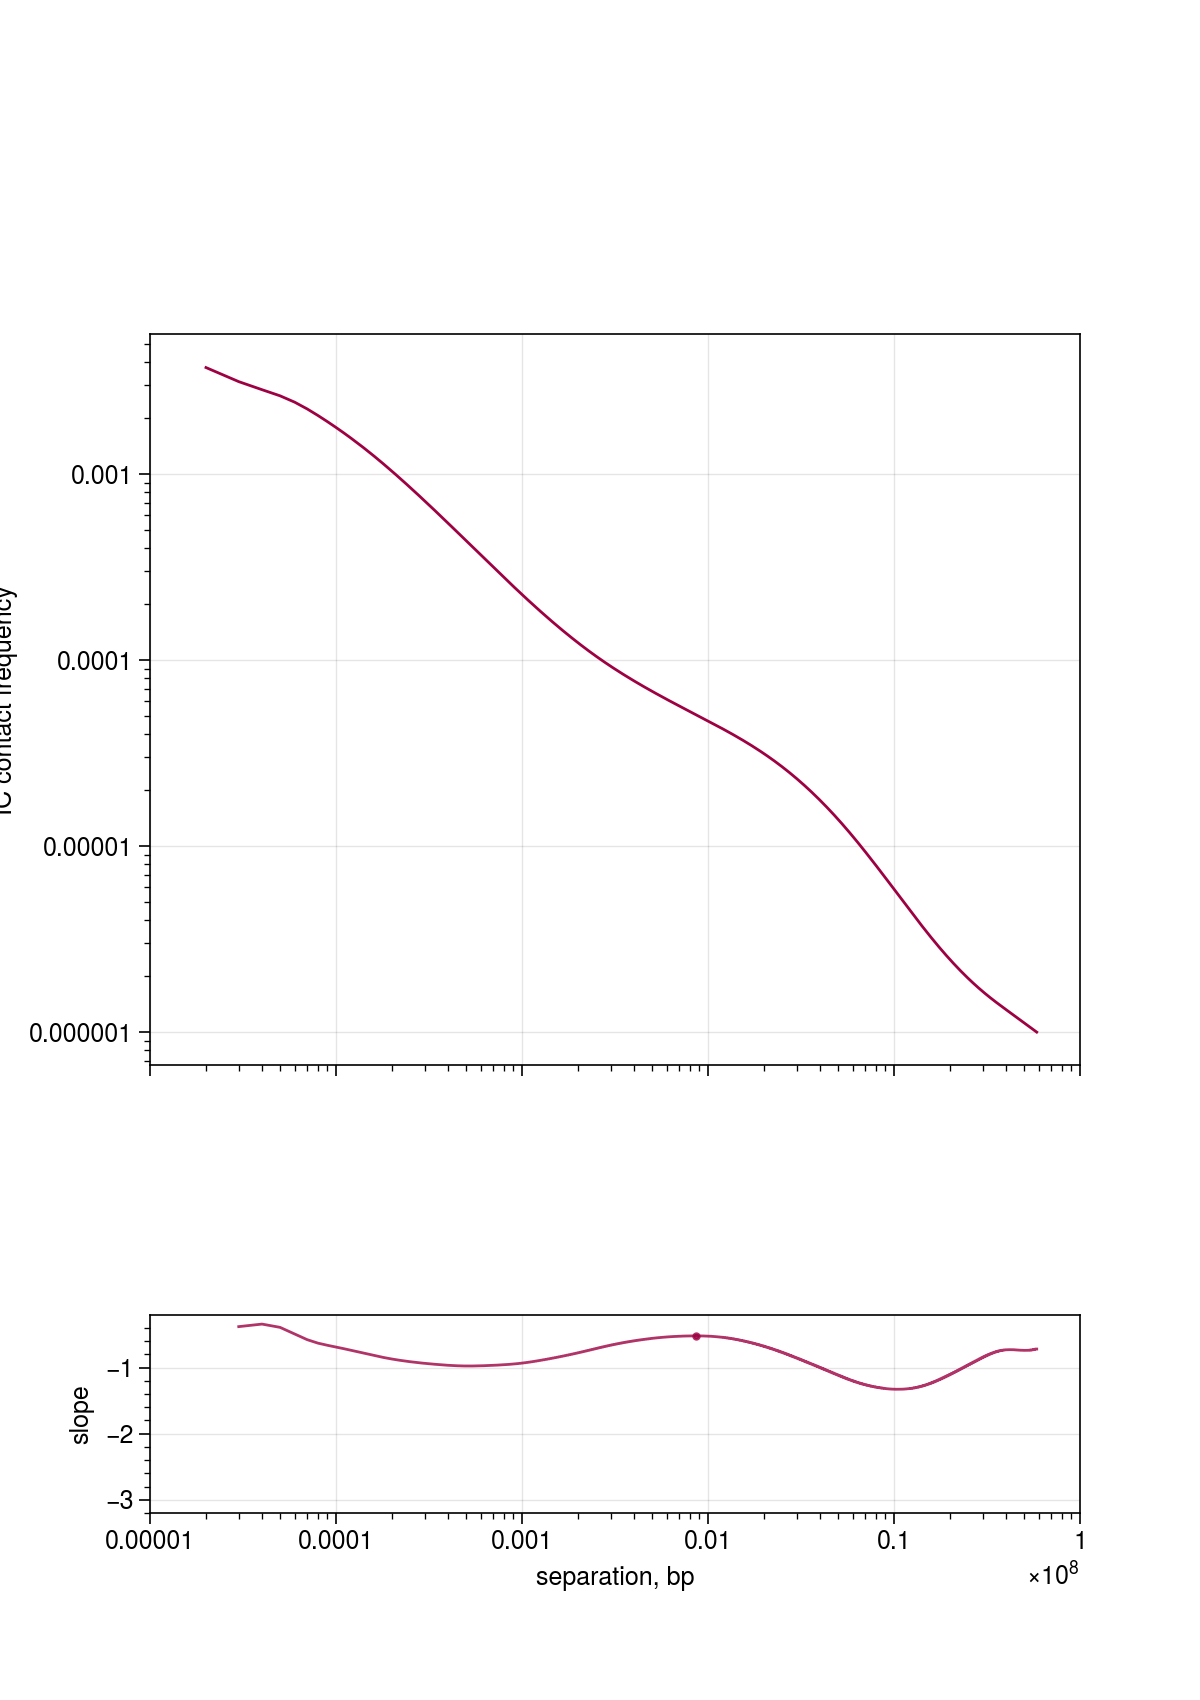

In [88]:
f, axs = plt.subplots(
    figsize=(6,8.5),
    nrows=2, 
    gridspec_kw={'height_ratios':[10,2]}, 
    sharex=True)

ax = axs[0]
ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)

ax = axs[1]
ax.set(
    ylim=(-3.2,-0.2),
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)


for i, (k, title) in enumerate(zip(keys, titles)):
        
    cvd_smooth_agg = cvd_dct[genome][k]
    cvd_merged = cvd_smooth_agg.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    der = np.gradient(np.log(cvd_merged['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged['s_bp']))
    
    ax = axs[0]
    ax.loglog(
        cvd_merged['s_bp'],
        cvd_merged['balanced.avg.smoothed.agg'],
        '-',
        markersize=2, 
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )

    ax = axs[1]
    ax.semilogx(
        cvd_merged['s_bp'],
        der,
        alpha=0.8,
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )
    
    # Smaller hump
    try: 
        idx = np.where((cvd_merged.s_bp>1e4) & (cvd_merged.s_bp<1e5))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        first_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]
        
        if not idx_true==idx[0]:
            ax.semilogx(
                cvd_merged['s_bp'].iloc[idx_true],
                der[[idx_true]],
                'o',
                markersize=2,
                alpha=0.8,
                linewidth=1 if not 'hpf' in title else 2,
                label=title,
                color=cmap.colors[i]
            )
    except Exception:
        pass
    
    # Larger hump
    try:
        idx = np.where((cvd_merged.s_bp>5*1e5) & (cvd_merged.s_bp<1e7))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        second_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]

        ax.semilogx(
            cvd_merged['s_bp'].iloc[idx_true],
            der[[idx_true]],
            'o',
            markersize=2,
            alpha=0.8,
            linewidth=1 if not 'hpf' in title else 2,
            label=title,
            color=cmap.colors[i]
        )
    except Exception:
        pass
    
axs[0].legend()
f.tight_layout()

plt.savefig(f'../figures/003_scalings_danRer11_{resolution}.pdf')
plt.show()

### Read Abramo scalings

In [ ]:
genome = "hg38_Abramo"
keys = [
    'G2-M_sample_0_hours',
    'released_0.5_hours',
    'released_1_hour',
    'released_1.5_hours',
    'released_1.75_hours',
    'released_2_hours',
    'released_2.25_hours',
    'released_2.5_hours',
    'released_2.75_hours',
    'released_3_hours',
    'released_3.25_hours',
    'released_3.5_hours',
    'released_4_hours',
    'released_4.5_hours',
    'released_5_hours',
    'released_6_hours',
    'released_7_hours',
    'released_8_hours',
    'released_9_hours',
    'released_10_hours',
    'released_11_hours',
    'released_12_hours',
    'asynchronous_control',
]
titles = [x.split('_')[-2] + (' h' if not 'control' in x else '') for x in keys]

In [ ]:
cmap = mpl.cm.get_cmap('spectral', len(titles))
cmap.colors = [cmap(x) for x in range(cmap.N)]

In [ ]:
f, axs = plt.subplots(
    figsize=(6,8.5),
    nrows=2, 
    gridspec_kw={'height_ratios':[10,2]}, 
    sharex=True)

ax = axs[0]
ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)

ax = axs[1]
ax.set(
    ylim=(-2.2,-0.2),
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)


for i, (k, title) in enumerate(zip(keys, titles)):
    
    cvd_smooth_agg = cvd_dct[genome][k]
    cvd_merged = cvd_smooth_agg.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    der = np.gradient(np.log(cvd_merged['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged['s_bp']))
    
    ax = axs[0]
    ax.loglog(
        cvd_merged['s_bp'],
        cvd_merged['balanced.avg.smoothed.agg'],
        '-',
        markersize=2, 
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )

    ax = axs[1]
    ax.semilogx(
        cvd_merged['s_bp'],
        der,
        alpha=0.8,
        linewidth=1,
        label=title,
        color=cmap.colors[i]
    )
    
    # Smaller hump
    try: 
        idx = np.where((cvd_merged.s_bp>2*1e4) & (cvd_merged.s_bp<1e6))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]

        first_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]
        
        if not idx_true==idx[0]:
            ax.semilogx(
                cvd_merged['s_bp'].iloc[idx_true],
                der[[idx_true]],
                'o',
                markersize=2,
                alpha=0.8,
                linewidth=1 if not 'hpf' in title else 2,
                label=title,
                color=cmap.colors[i]
            )
    except Exception:
        pass
    
    # Larger hump
    try:
        idx = np.where((cvd_merged.s_bp>3*1e6) & (cvd_merged.s_bp<1e7))[0]
        idx_max = np.argmax(der[idx])
        idx_true = idx[idx_max]
        
        second_hump_dct[genome][k] = [f"{genome}", f"{k}", idx_true, cvd_merged['s_bp'].iloc[idx_true], der[idx_true] ]

        ax.semilogx(
            cvd_merged['s_bp'].iloc[idx_true],
            der[[idx_true]],
            'o',
            markersize=2,
            alpha=0.8,
            linewidth=1 if not 'hpf' in title else 2,
            label=title,
            color=cmap.colors[i]
        )
    except Exception:
        pass
    
axs[0].legend()
f.tight_layout()

plt.savefig(f'../figures/003_scalings_Abramo2019_{resolution}.pdf')
plt.show()

## Visualize positions of humps

In [ ]:
df = pd.DataFrame.from_dict(second_hump_dct, orient="index")
df.columns = ["genome", "title", "peak_bin", "peak_coord", "peak_value"]
df.loc[:, "name"] = df.apply(lambda x: x.title.replace(x.genome+"_", ""), axis=1)

In [ ]:
import seaborn.objects as so

#### Second hump

In [ ]:
p = (
    so.Plot(
        df[::-1].query("genome!='danRer11_admixtures'"),
        y="name",
        x="peak_coord",
        color="genome",
    )
    .layout(size=(7, 15))
    .scale( x="log" )
    .add(
        so.Line()
    )
    .add(
        so.Dot()
    )
    .theme({"axes.facecolor": "w", "axes.edgecolor": "grey", 'grid.color': 'lightgrey',})
)

p.save("../figures/003_scalings_second_hump.pdf")

p.plot()


#### First hump

In [ ]:
df = pd.DataFrame.from_dict(first_hump_dct, orient="index")
df.columns = ["genome", "title", "peak_bin", "peak_coord", "peak_value"]
df.loc[:, "name"] = df.apply(lambda x: x.title.replace(x.genome+"_", ""), axis=1)

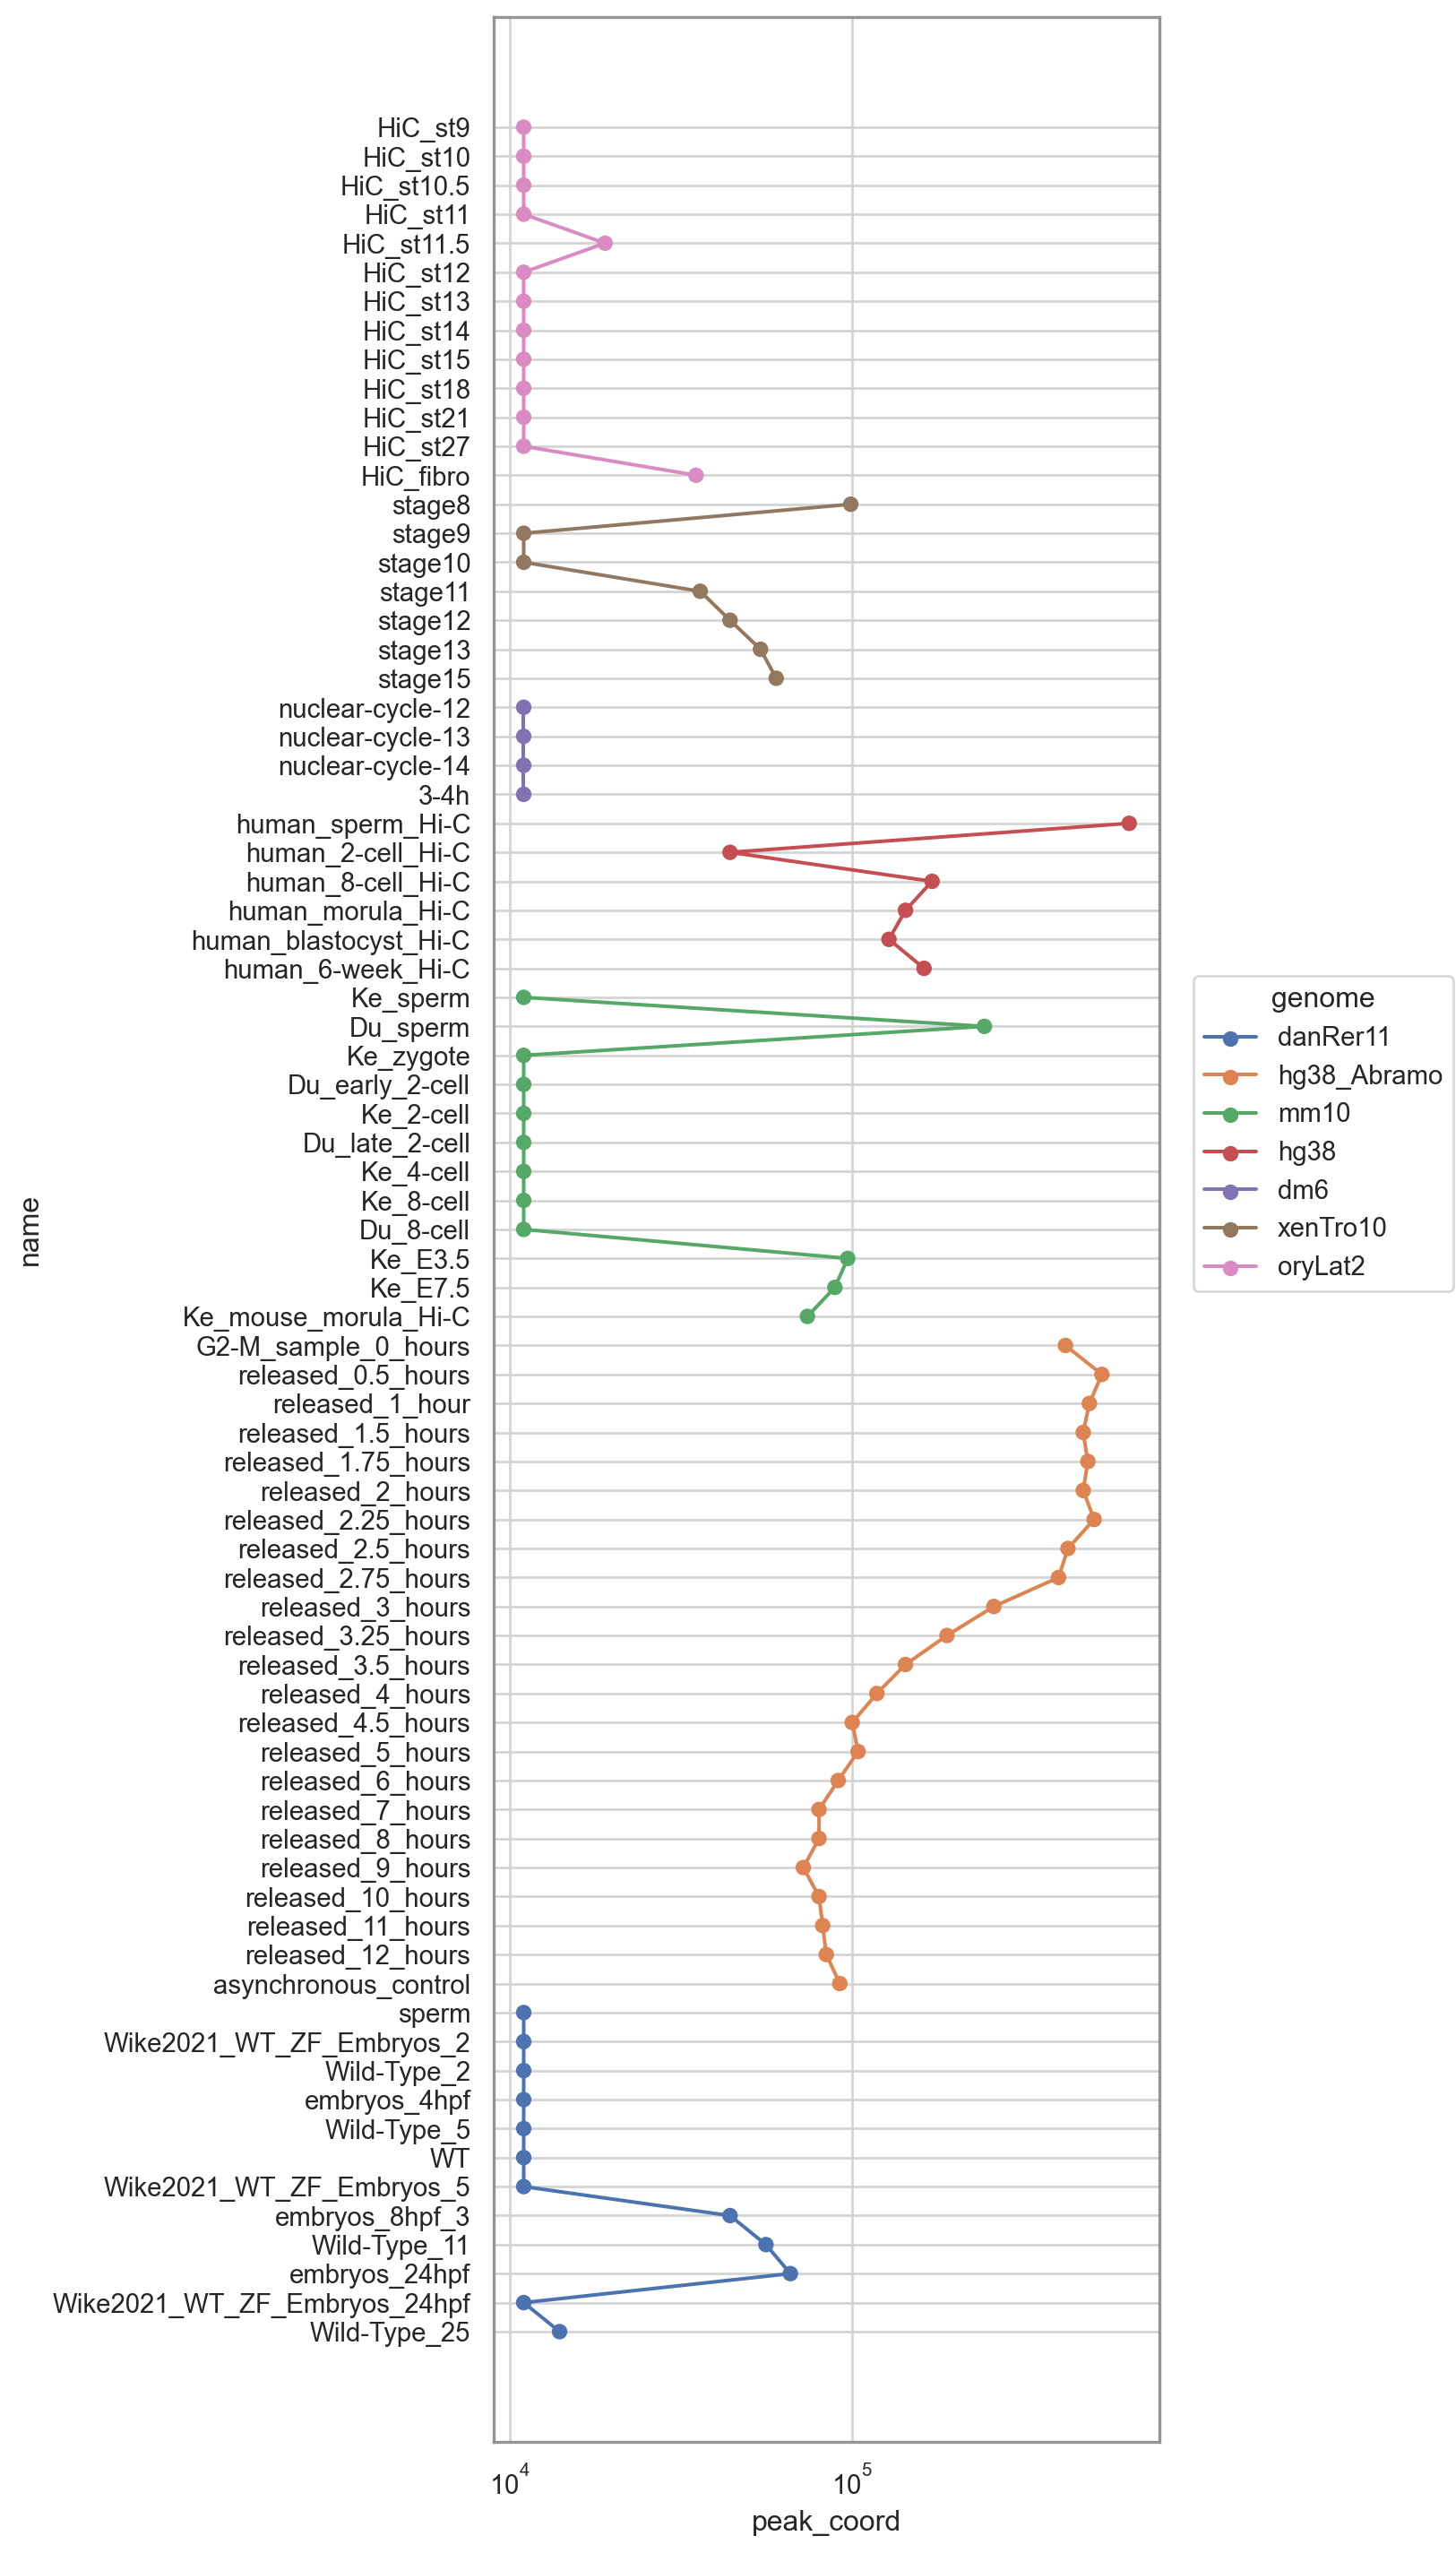

In [144]:
p = (
    so.Plot(
        df[::-1].query("genome!='danRer11_admixtures'"),
        y="name",
        x="peak_coord",
        color="genome",
    )
    .layout(size=(7, 15))
    .scale( x="log" )
    .add(
        so.Line()
    )
    .add(
        so.Dot()
    )
    .theme({"axes.facecolor": "w", "axes.edgecolor": "grey", 'grid.color': 'lightgrey',})
)

# p.save("../figures/003_scalings_first_hump.pdf")

p.plot()
